Some sort of lognormal composition

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

import matplotlib.pyplot as plt
from utils import *
from models import *

In [1193]:
p = np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
L = p*p

survey = IncomeDistribution("../jsoncache/COL_3_2014.json")
print(survey.data['dataset']['source'])

L = survey.lorenz_points_L
p = survey.lorenz_points_p

#L = np.hstack(([0.0], [survey.min_ppp_month/survey.mean_ppp_month*1/survey.sample_N], L))
#p = np.hstack(([0.0], [1/survey.sample_N], p))
L = np.hstack(([0.0], L))
p = np.hstack(([0.0], p))

mean = survey.mean_ppp_month
print("Mean:", mean)
print("Max:", survey.max_ppp_month)
print("Min:", survey.min_ppp_month)

if False:
    if (np.any(L < 0)):
        print("Dropping negative points:",np.sum(L < 0))
        p = p[L >= 0]
        L = L[L >= 0]    

    if (np.any(L[1:] == 0)):
        print ("Dropping interior zero points", np.sum(L[1:] == 0))
        p = np.hstack((p[0], p[1:][L[1:] != 0]))
        L = np.hstack((L[0], L[1:][L[1:] != 0]))
    
L[:5]

COL_N2014Y
Mean: 450.73
Max: 33702.3
Min: 0.0


array([ 0.        ,  0.00013874,  0.00065581,  0.0014253 ,  0.0023952 ])

In [1243]:
p = np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
L = p*p

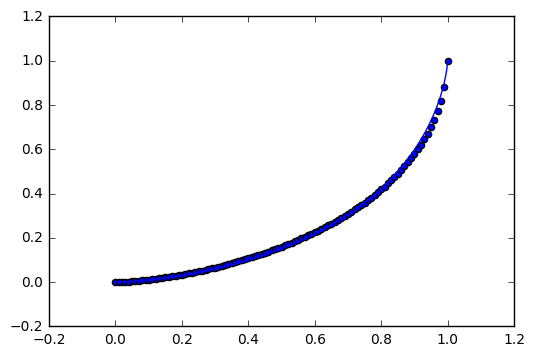

In [1194]:
# Lognormal estimation

lorenz_ln = lambda p, sigma: scipy.stats.norm.cdf(scipy.stats.norm.ppf(p) - sigma)
inv_lorenz_ln = lambda L, sigma: scipy.stats.norm.cdf(scipy.stats.norm.ppf(L) + sigma)

# estimate params
dp = np.diff(p)
G = 1 - sum(0.5 * dp * (L[1:] + L[:-1])) / 0.5
sigma = scipy.stats.norm.ppf((G + 1)/2, 0, 1) * math.sqrt(2);

pgrid = np.linspace(0, 1, 5000)
plt.plot(pgrid, lorenz_ln(pgrid, sigma))
plt.scatter(p, L)

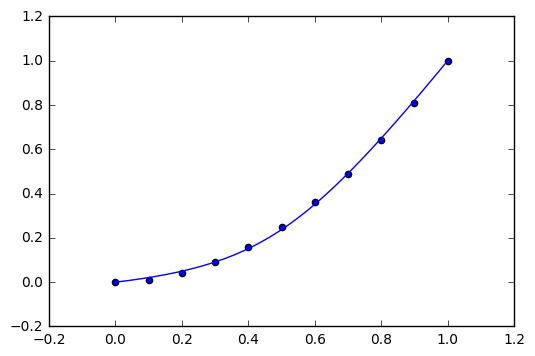

In [1245]:
# General quadratic estimation

def lorenz_gq(p,a,b,d): # Villasenor & Arnold eq 6(b)
    e = -(a + b + d +1)
    alpha = b**2 - 4*a
    beta = 2*b*e - 4*d
    
    result = (-(b*p + e) - (alpha*p**2 + beta*p + e**2)**0.5)/2
    return result

inv_lorenz_gq = np.vectorize(lambda L, a,b,d: scipy.optimize.brentq(lambda p: lorenz_gq(p,a,b,d)-L, a=0, b=1))

GQ_lhs = L * (1 - L)
GQ_a   = p*p - L
GQ_b   = L * (p - 1)
GQ_d   = p - L

# Note: we exclude the endpoints of the Lorenz curve from estimation hence 1:-1
import statsmodels.formula.api as sm
result = sm.OLS(GQ_lhs[1:-1], np.transpose(np.vstack((GQ_a[1:-1], GQ_b[1:-1], GQ_d[1:-1])))).fit()
a = result.params[0]
b = result.params[1]
d = result.params[2]

pgrid = np.linspace(0, 1, 5000)
plt.plot(pgrid, lorenz_gq(pgrid, a,b,d))
plt.scatter(p, L)

In [1242]:
lorenz_gq(0.5,0,-2,-.2)

-0.43166247903554006

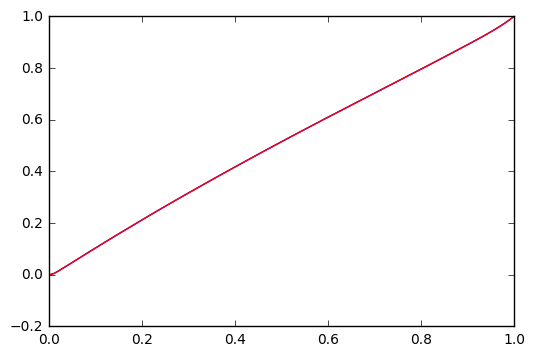

In [1206]:
# Inner function estimation

LNp = inv_lorenz_ln(L, sigma)
#LNp = np.hstack(([0], inv_lorenz_gq(L[1:-1], a,b,d), [1]))
plt.plot(p, LNp)

inner = scipy.interpolate.UnivariateSpline(p, LNp, w=[1000]+((len(p)-2)*[1.0])+[1000.0], k=4, s = 0.0000001)
plt.plot(pgrid, inner(pgrid), color="r")

array([ 0.        ,  0.00013874,  0.00065581,  0.0014253 ,  0.0023952 ])

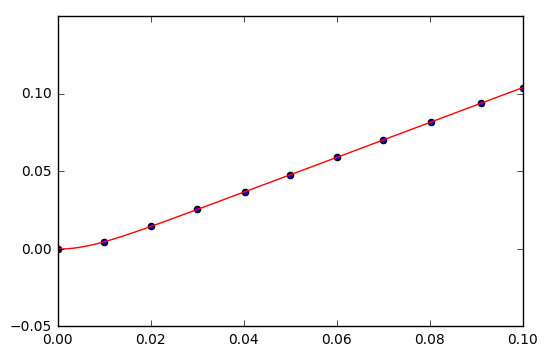

In [1207]:
pgrid2 = np.linspace(0,0.1,1000)
plt.plot(pgrid, inner(pgrid), color="r")
plt.scatter(p, LNp)
plt.xlim(0,0.1)
plt.ylim(-0.05, 0.15)
L[:5]

/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1731: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


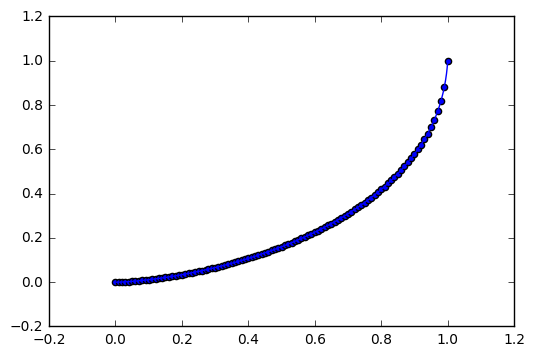

In [1208]:
lorenz_comp = lambda p: lorenz_ln(inner(p), sigma)
#lorenz_comp = lambda p: lorenz_gq(inner(p), a,b,d)
plt.plot(pgrid, lorenz_comp(pgrid))
plt.scatter(p, L)

/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


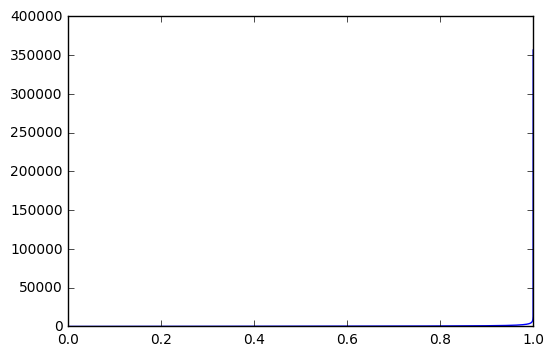

In [1209]:
quantile_comp_numerical = lambda p: mean * derivative(lorenz_comp)(p)

def quantile_comp(p):
    mp = inner(p)
    dmp = inner.derivative()(p)
    norm_quant_mp = scipy.stats.norm.ppf(mp)
    
    result = mean * scipy.stats.norm.pdf(norm_quant_mp - sigma) / scipy.stats.norm.pdf(norm_quant_mp) * dmp
    return result

#quantile_comp = quantile_comp_numerical

plt.plot(pgrid, quantile_comp(pgrid))

In [1218]:
print(quantile_comp(0.01))
print(quantile_comp_numerical(0.000001))

15.0755557405
nan


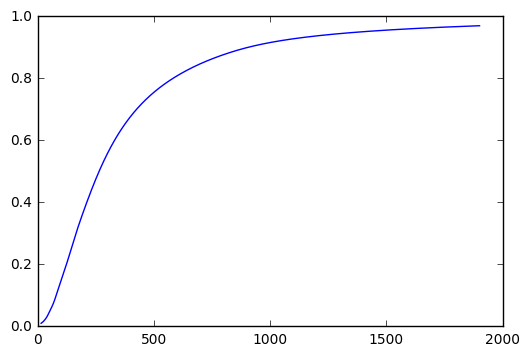

In [1219]:
dist_comp = inverse(quantile_comp, domain=(0.01,0.99999))
ygrid = np.linspace(min(quantile_comp(0.01), 0), quantile_comp(0.97),1000)
plt.plot(ygrid, dist_comp(ygrid))

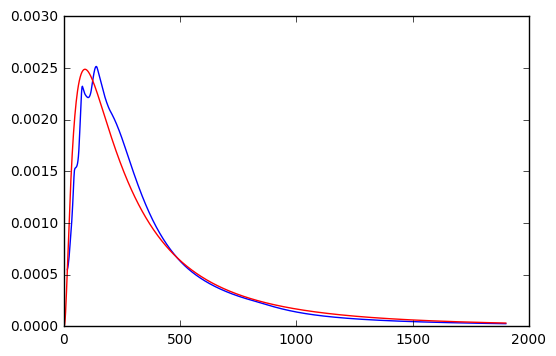

In [1220]:
dens_comp = derivative(dist_comp, dx=1e-7*mean)
plt.plot(ygrid, dens_comp(ygrid))

mu = math.log(mean) - 0.5 * sigma ** 2;
plt.plot(ygrid, scipy.stats.lognorm.pdf(ygrid, s=sigma, scale=math.exp(mu)), color="r")

In [1221]:
print(dist_comp(survey.poverty_line_ppp_month))
print(survey.data['dist']['HC'])
print(scipy.stats.lognorm.cdf(survey.poverty_line_ppp_month, s=sigma, scale=math.exp(mu)))

0.057430302104868124
0.0567811
0.0703134880954


In [1222]:
print(quantile_comp(0.5))
print(survey.data['dist']['median_ppp'])
print(scipy.stats.lognorm.ppf(0.5, s=sigma, scale=math.exp(mu)))

264.478889101
264.68
264.538182275


In [1254]:
survey.__class__.__name__

'IncomeDistribution'